In [ ]:
import cv2
from google.colab.patches import cv2_imshow

import pandas as pd

import numpy as np

import random

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

from keras.models import Sequential
from keras.optimizers import Adam,Adagrad
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten

from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
IMAGE_HEIGHT=66
IMAGE_WIDTH=200
IMAGE_CHANNELS =3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
test_size=0.2
keep_prob=0.5
nb_epoch=50
samples_per_epoch=20000
batch_size=40
save_best_only=True
learning_rate=1.0e-4

In [ ]:
# columns=['center','left','right','steering','brake','throttle','speed']
data=pd.read_csv('/content/gdrive/My Drive/log.csv')

In [ ]:
data=data[['center','left','right','steering']]

In [ ]:
def name_corrector(x):
  temp=x.strip().split('\\')
  temp=temp[-1]
  return temp

In [ ]:
data['center']=data['center'].apply(lambda x: name_corrector(x))
data['left']=data['left'].apply(lambda x: name_corrector(x))
data['right']=data['right'].apply(lambda x: name_corrector(x))

In [ ]:
center=pd.DataFrame()
center['img']=data['center']
center['steering']=data['steering']

In [ ]:
left=pd.DataFrame()
left['img']=data['left']
left['steering']=data['steering']+0.2 #augmenting the steering

In [ ]:
right=pd.DataFrame()
right['img']=data['right']
right['steering']=data['steering']-0.2 #augmenting the steering

In [ ]:
rcenter=pd.DataFrame()
rcenter['img']='R'+data['center']
rcenter['steering']=-data['steering']

In [ ]:
rleft=pd.DataFrame()
rleft['img']='R'+data['left']
rleft['steering']=-data['steering']

In [ ]:
rright=pd.DataFrame()
rright['img']='R'+data['right']
rright['steering']=-data['steering']

In [ ]:
def img_roter(x):
  if(x[0]!='R'):
    img=mpimg.imread('/content/gdrive/My Drive/img/'+x)
    img=cv2.flip(img, 1)
    mpimg.imsave('/content/gdrive/My Drive/img/'+'R'+x, img)

In [ ]:
data=pd.read_csv('/content/gdrive/My Drive/log.csv')
data['img'].apply(lambda x: img_roter(x))

0        None
1        None
2        None
3        None
4        None
         ... 
26183    None
26184    None
26185    None
26186    None
26187    None
Name: img, Length: 26188, dtype: object

In [ ]:
center['img'].apply(lambda x: img_roter(x))

0       None
1       None
2       None
3       None
4       None
        ... 
2675    None
2676    None
2677    None
2678    None
2679    None
Name: img, Length: 2680, dtype: object

In [ ]:
left['img'].apply(lambda x: img_roter(x))

In [ ]:
right['img'].apply(lambda x: img_roter(x))

In [ ]:
temp=pd.concat([center,left,right,rcenter,rleft,rright], ignore_index=True)
temp.to_csv('/content/gdrive/My Drive/temp.csv',index=False) 

NameError: ignored

In [ ]:
def add_path(x):
  return '/content/gdrive/My Drive/img/'+x

#we changed the data dataframe 
data=pd.read_csv('/content/gdrive/My Drive/log.csv')
data['img']=data['img'].apply(lambda x: add_path(x))

In [ ]:
data=pd.read_csv('/content/gdrive/My Drive/log.csv')

In [ ]:
def balanceData(data,display=True):
    nBin = 31
    samplesPerBin = 600
    hist, bins = np.histogram(data['steering'], nBin)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['steering']), np.max(data['steering'])), (samplesPerBin, samplesPerBin))
        plt.show()

In [ ]:
def balancer(data):
    nBin = 31
    samplesPerBin = 600
    hist, bins = np.histogram(data['steering'], nBin)
    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['steering'])):
            if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeindexList.extend(binDataList)
 
    print('Removed Images:', len(removeindexList))
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    return data,removeindexList

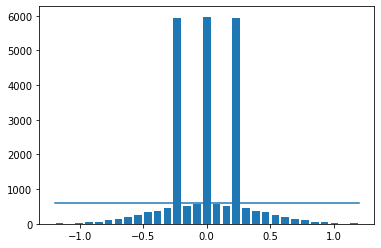

In [ ]:
#before removing data
balanceData(data)

In [ ]:
data,removed=balancer(data) #we will use removed this for testing

Removed Images: 16054
Remaining Images: 7952


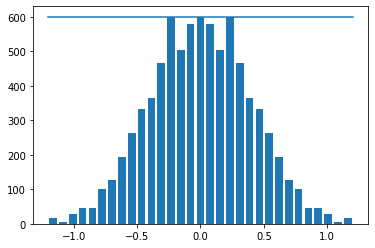

In [ ]:
#after removing data
balanceData(data)

In [ ]:
def crop(img):
    temp=img[:,60:-25, :, :]
    return temp

def resizer(img):
    return cv2.resize(img,(IMAGE_WIDTH, IMAGE_HEIGHT),cv2.INTER_AREA)

def rgb2yuv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

def random_shadow(image):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

def random_brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

In [ ]:
def loadData(path, data):
  imagesPath = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    imagesPath.append(f'{path}/image/{indexed_data[0]}')
    steering.append(float(indexed_data[1]))
  imagesPath = np.asarray(imagesPath)
  steering = np.asarray(steering)
  return imagesPath, steering

In [ ]:
# imagesPath, steerings = loadData('/content/gdrive/My Drive',data)
imagesPath='/content/gdrive/My Drive/image/'+data['img']
steerings=data['steering']

In [ ]:
xTrain, xVal, yTrain, yVal = train_test_split(imagesPath, steerings, test_size=0.2,random_state=42)
print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))

Total Training Images:  6361
Total Validation Images:  1591


In [ ]:
from imgaug import augmenters as iaa
def augmentImage(imgPath,steering):
  img =  mpimg.imread(imgPath)
  if np.random.rand() < 0.5:
    pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    img = pan.augment_image(img)
  if np.random.rand() < 0.5:
    zoom = iaa.Affine(scale=(1, 1.2))
    img = zoom.augment_image(img)
  if np.random.rand() < 0.5:
    brightness = iaa.Multiply((0.2, 1.2))
    img = brightness.augment_image(img)
  # if np.random.rand() < 0.5:
  #   img = cv2.flip(img, 1)
  #   steering = -steering
  return img, steering

In [ ]:
def preProcess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

In [ ]:
def dataGen(imagesPath, steeringList, batchSize, trainFlag):
  while True:
    imgBatch = []
    steeringBatch = []

    for i in range(batchSize):
      index = random.randint(0, len(imagesPath) - 1)
      if trainFlag:
        img, steering = augmentImage(imagesPath[index], steeringList[index])
      else:
        img = mpimg.imread(imagesPath[index])
      steering = steeringList[index]
      img = preProcess(img)
      imgBatch.append(img)
      steeringBatch.append(steering)
    yield (np.asarray(imgBatch),np.asarray(steeringBatch))

In [ ]:
xTrain=np.array(xTrain)
xVal=np.array(xVal)
yTrain=np.array(yTrain)
yVal=np.array(yVal)

In [ ]:
#Our model 1
model = Sequential()
model.add(Conv2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
model.add(Conv2D(36, (5, 5), (2, 2), activation='elu'))
model.add(Conv2D(48, (5, 5), (2, 2), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation = 'elu'))
model.add(Dense(50, activation = 'elu'))
model.add(Dense(10, activation = 'elu'))
model.add(Dense(1))
model.summary()
model.compile(Adam(lr=0.0001),loss='mse')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)             

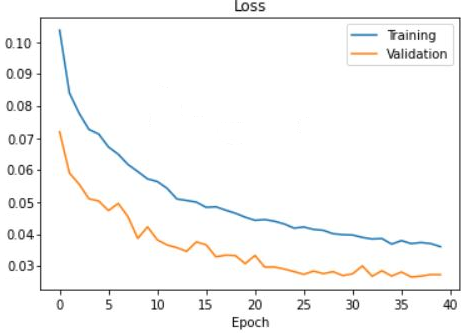

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
model.save('/content/gdrive/My Drive/modelNvidia.h5')
print('Model Saved')

Model Saved
